In [1]:
import gym
import random
import math
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

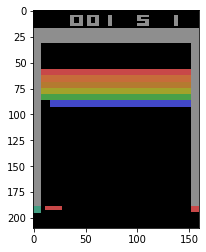

In [3]:
env = gym.make('Breakout-v0')
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)
env.close()

In [4]:
from collections import namedtuple

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory():

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DNet(nn.Module):
    def __init__(self, nA):
        super(DNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(9 * 6 * 64, 512)
        self.fc2 = nn.Linear(512, nA)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  
        x = F.relu(self.bn2(self.conv2(x)))  
        x = F.relu(self.bn3(self.conv3(x)))  
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        return self.fc2(x)

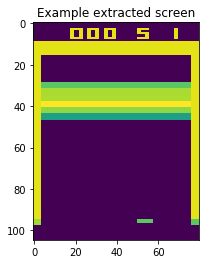

In [6]:
pre_process = T.Compose([
    T.ToPILImage(),
    T.Grayscale(),
    T.ToTensor()
])

def get_screen():
    screen = env.render(mode='rgb_array').transpose(2, 0, 1)
    _, screen_height, screen_width = screen.shape
    screen = screen[:, ::2, ::2]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    screen = pre_process(screen).unsqueeze(0).to(device)
    return screen

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze().numpy())
plt.title('Example extracted screen')
plt.show()

In [7]:
EPISODES = 1000
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
MEMORY_CAPACITY = 10000
TARGET_UPDATE = 10
LEARN_FREQ = 4
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN():
    def __init__(self, env): 
        self.env = env
        self.n_action = self.env.action_space.n
        self.mem = ReplayMemory(MEMORY_CAPACITY)
        
        self.step = 0

        self.policy_net = DNet(self.n_action).to(device)
        self.target_net = DNet(self.n_action).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.RMSprop(self.policy_net.parameters(),
    lr=0.00025, eps=0.01, alpha=0.95)
        
        self.loss_func = nn.SmoothL1Loss()
        
    def choose_action(self, state):  
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.step / EPS_DECAY)
        if np.random.uniform() > eps_threshold:
            with torch.no_grad():
                q, action = self.policy_net(Variable(state.to(device))).data.cpu().max(1)
        else:
            action = np.random.randint(0, self.n_action)
        
        return action
    
    def optimize_model(self):
        if len(self.mem) < BATCH_SIZE:
            return
        transitions = self.mem.sample(BATCH_SIZE)
        
        batch = Transition(*zip(*transitions))
    
        state_batch = torch.cat(batch.state).to(device)
        action_batch = torch.cat(batch.action).to(device)
        reward_batch = torch.cat(batch.reward).to(device)
        next_state_batch = torch.cat(batch.next_state).to(device)
        done_batch = torch.cat(batch.done).to(device)
        
        state_q_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
        
        next_state_q_values = self.target_net(next_state_batch).detach().max(1)[0]
        
        expected_state_action_values = next_state_q_values * GAMMA * (1 - done_batch)
        
        loss = self.loss_func(state_q_values, reward_batch + expected_state_action_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
#         print("loss:", loss)
        
    def train(self):
        img = plt.imshow(env.render(mode='rgb_array')) # only call this once
        for e in range(EPISODES):
            self.env.reset()
            done = False
            while not done:
                if self.step % LEARN_FREQ == 0:
                    self.optimize_model()
                if self.step % TARGET_UPDATE == 0:
                    self.target_net.load_state_dict(self.policy_net.state_dict())
                self.step += 1
                
                state = get_screen()
                
                action = self.choose_action(state)
                _, reward, done, _ = env.step(action)
                
                next_state = get_screen()
                
                self.mem.push(state, torch.LongTensor([action]), 
                              next_state, torch.Tensor([reward]), torch.Tensor([done]))
                
                
                img.set_data(self.env.render(mode='rgb_array')) # just update the data
                display.display(plt.gcf())
                display.clear_output(wait=True)
            print(self.step)

KeyboardInterrupt: 

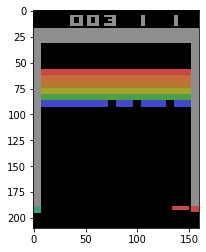

In [8]:
dqn = DQN(env)
dqn.train()

In [9]:
mem = dqn.mem

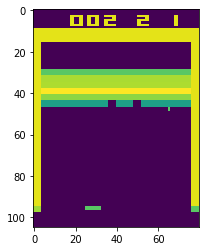

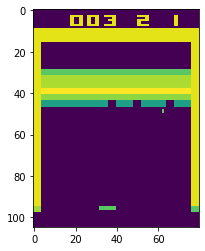

torch.Size([105, 80])


In [46]:
while True:
    transitions = mem.sample(1)
    batch = Transition(*zip(*transitions))
    reward_batch = torch.cat(batch.reward).to(device)
    if reward_batch.item():
        state = batch.state[0].squeeze()
        plt.imshow(state.cpu().numpy())
        plt.show()
        next_state = batch.next_state[0].squeeze()
        plt.imshow(next_state.cpu().numpy())
        plt.show()
        print(state.shape)
        break